<a href="https://colab.research.google.com/github/databyhuseyn/DeepLearning/blob/main/Shakespeare_Poet_and_Sentiment_Analysis_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

shakespeare_url = "https://homl.info/shakespeare"  # shortcut URL
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1115394/1115394 [==============================] - 0s 0us/step


In [ ]:
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [ ]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [ ]:
text_vec_layer = tf.keras.layers.TextVectorization(split="character",
                                                   standardize="lower")
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]

In [ ]:
text_vec_layer.get_vocabulary()

['',
 '[UNK]',
 ' ',
 'e',
 't',
 'o',
 'a',
 'i',
 'h',
 's',
 'r',
 'n',
 '\n',
 'l',
 'd',
 'u',
 'm',
 'y',
 'w',
 ',',
 'c',
 'f',
 'g',
 'b',
 'p',
 ':',
 'k',
 'v',
 '.',
 "'",
 ';',
 '?',
 '!',
 '-',
 'j',
 'q',
 'x',
 'z',
 '3',
 '&',
 '$']

In [ ]:
encoded -= 2  # drop tokens 0 (pad) and 1 (unknown), which we will not use
n_tokens = text_vec_layer.vocabulary_size() - 2  # number of distinct chars = 39
dataset_size = len(encoded)  #

In [ ]:
n_tokens

39

In [ ]:
dataset_size

1115394

In [ ]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [ ]:
# sequence = [0, 1, 2, 3, 4, 5]

# windows: [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5]]

# input-target pairs: [([0, 1, 2], [1, 2, 3]), ([1, 2, 3], [2, 3, 4]), ([2, 3, 4], [3, 4, 5])]

# [[[1, 2, 3], [2, 3, 4]], [[3, 4, 5]]] (inputs)
# [[[2, 3, 4], [3, 4, 5]], [[4, 5, 6]]] (targets)


In [ ]:
list(to_dataset(tf.range(10), 3))

[(<tf.Tensor: shape=(7, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3],
         [2, 3, 4],
         [3, 4, 5],
         [4, 5, 6],
         [5, 6, 7],
         [6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(7, 3), dtype=int32, numpy=
  array([[1, 2, 3],
         [2, 3, 4],
         [3, 4, 5],
         [4, 5, 6],
         [5, 6, 7],
         [6, 7, 8],
         [7, 8, 9]], dtype=int32)>)]

In [ ]:
list(to_dataset(text_vec_layer(["To be"])[0], length=4))

[(<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 4,  5,  2, 23]])>,
  <tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 5,  2, 23,  3]])>)]

In [ ]:
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True,
                       seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

# Building and Training the Char-RNN Mode

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_shakespeare_model", monitor="val_accuracy", save_best_only=True)
history = model.fit(train_set, validation_data=valid_set, epochs=3,
                    callbacks=[model_ckpt])

Epoch 1/3
   9017/Unknown - 978s 104ms/step - loss: 1.5205 - accuracy: 0.5418

KeyboardInterrupt: 

In [ ]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    model
])

NameError: name 'model' is not defined

In [ ]:
# extra code – downloads a pretrained model
from pathlib import Path
url = "https://github.com/ageron/data/raw/main/shakespeare_model.tgz"
path = tf.keras.utils.get_file("shakespeare_model.tgz", url, extract=True)
model_path = Path(path).with_name("shakespeare_model")
shakespeare_model = tf.keras.models.load_model(model_path)

352865/352865 [==============================] - 0s 0us/step


In [ ]:
y_proba = shakespeare_model.predict(["To be or not to b"])[0, -1]
y_pred = tf.argmax(y_proba)  # choose the most probable character ID
text_vec_layer.get_vocabulary()[y_pred + 2]

1/1 [==============================] - 1s 1s/step


'e'

# Generating Fake Shakespearean Text

In [ ]:

log_probas = tf.math.log([[0.5, 0.4, 0.1]])  # probas = 50%, 40%, and 10%
tf.random.set_seed(42)
tf.random.categorical(log_probas, num_samples=8)

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 1, 0, 2, 1, 0, 0, 1]])>

In [ ]:
def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict([text])[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

In [18]:
def extend_text(text, n_chars=100, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [ ]:
tf.random.set_seed(42)

In [ ]:
print(extend_text('''Now we are even''', temperature=0.01))

1/1 [==============================] - 0s 56ms/step
Now we are even to the death,
and then the strange daughter is a proper man and the death,
and then the sea to the 


In [ ]:
print(extend_text("now we are even", temperature=1))

1/1 [==============================] - 0s 58ms/step
now we are even to thy partned?

isabella:
then, most marked awaked her son, in cause.

juliet:
i have at fire soft


In [ ]:
print(extend_text("To be or not to be", temperature=100))

1/1 [==============================] - 0s 40ms/step
To be or not to be&vm:o.ns3
h$,xou?3iigarrgia
 n?p-!t'yffstu:u fescbhrhpmflkpn'ojsgeuwt?o!r.s?iszc
rgabtfd$
peruvdok.t


# Stateful RNN

In [ ]:
def to_dataset_for_stateful_rnn(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(length + 1)).batch(1)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000],
                                                 length)
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)

NameError: name 'encoded' is not defined

In [ ]:
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

In [ ]:
# extra code – shows one way to prepare a batched dataset for a stateful RNN

import numpy as np

def to_non_overlapping_windows(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    return ds.flat_map(lambda window: window.batch(length + 1))

def to_batched_dataset_for_stateful_rnn(sequence, length, batch_size=32):
    parts = np.array_split(sequence, batch_size)
    datasets = tuple(to_non_overlapping_windows(part, length) for part in parts)
    ds = tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

list(to_batched_dataset_for_stateful_rnn(tf.range(20), length=3, batch_size=2))

In [ ]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_stateful_shakespeare_model",
    monitor="val_accuracy",
    save_best_only=True)

In [ ]:
# Warning: the following cell will take a while to run (possibly an hour if you are not using a GPU).
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(stateful_train_set, validation_data=stateful_valid_set,
                    epochs=7, callbacks=[ResetStatesCallback(), model_ckpt])

In [ ]:
stateless_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

In [ ]:

stateless_model.build(tf.TensorShape([None, None]))

In [ ]:
stateless_model.set_weights(model.get_weights())

In [ ]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    stateless_model
])

In [ ]:
tf.random.set_seed(42)

print(extend_text("to be or not to be", temperature=0.01))

# Sentiment Analysis

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds

raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

In [ ]:
for review, label in raw_train_set.take(4):
    print(review.numpy()[:200], "...")
    print("Label:", label.numpy())

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting " ...
Label: 0
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However ' ...
Label: 0
b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun' ...
Label: 0
b'This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf' ...
Label: 1


In [ ]:

vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

In [ ]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=2)

Epoch 1/2
704/704 [==============================] - 67s 85ms/step - loss: 0.6934 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 2/2
704/704 [==============================] - 30s 43ms/step - loss: 0.6952 - accuracy: 0.5017 - val_loss: 0.6996 - val_accuracy: 0.5016


# Masking

In [ ]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - 63s 80ms/step - loss: 0.5047 - accuracy: 0.7435 - val_loss: 0.4310 - val_accuracy: 0.8052
Epoch 2/5
704/704 [==============================] - 35s 50ms/step - loss: 0.3419 - accuracy: 0.8565 - val_loss: 0.3417 - val_accuracy: 0.8524
Epoch 3/5
704/704 [==============================] - 32s 46ms/step - loss: 0.2892 - accuracy: 0.8818 - val_loss: 0.2998 - val_accuracy: 0.8792
Epoch 4/5
704/704 [==============================] - 33s 47ms/step - loss: 0.2678 - accuracy: 0.8904 - val_loss: 0.3031 - val_accuracy: 0.8736
Epoch 5/5
704/704 [==============================] - 31s 44ms/step - loss: 0.2512 - accuracy: 0.8972 - val_loss: 0.3201 - val_accuracy: 0.8580


In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
token_ids = text_vec_layer(inputs)
mask = tf.math.not_equal(token_ids, 0)
Z = tf.keras.layers.Embedding(vocab_size, embed_size)(token_ids)
Z = tf.keras.layers.GRU(128, dropout=0.2)(Z, mask=mask)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(Z)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [ ]:
# extra code – compiles and trains the model, as usual
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - 65s 83ms/step - loss: 0.5577 - accuracy: 0.7037 - val_loss: 0.4476 - val_accuracy: 0.7968
Epoch 2/5
704/704 [==============================] - 35s 50ms/step - loss: 0.3661 - accuracy: 0.8459 - val_loss: 0.3300 - val_accuracy: 0.8652
Epoch 3/5
704/704 [==============================] - 34s 49ms/step - loss: 0.3033 - accuracy: 0.8751 - val_loss: 0.3193 - val_accuracy: 0.8660
Epoch 4/5
704/704 [==============================] - 32s 45ms/step - loss: 0.2806 - accuracy: 0.8845 - val_loss: 0.3162 - val_accuracy: 0.8644
Epoch 5/5
704/704 [==============================] - 33s 47ms/step - loss: 0.2612 - accuracy: 0.8935 - val_loss: 0.3032 - val_accuracy: 0.8716


In [ ]:

text_vec_layer_ragged = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size, ragged=True)
text_vec_layer_ragged.adapt(train_set.map(lambda reviews, labels: reviews))
text_vec_layer_ragged(["Great movie!", "This is DiCaprio's best role."])

<tf.RaggedTensor [[86, 18], [11, 7, 1, 116, 217]]>

In [ ]:

text_vec_layer(["Great movie!", "This is DiCaprio's best role."])

<tf.Tensor: shape=(2, 5), dtype=int64, numpy=
array([[ 86,  18,   0,   0,   0],
       [ 11,   7,   1, 116, 217]])>

In [ ]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer_ragged,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - 62s 83ms/step - loss: 0.5594 - accuracy: 0.7072 - val_loss: 0.5891 - val_accuracy: 0.7376
Epoch 2/5
704/704 [==============================] - 35s 50ms/step - loss: 0.3898 - accuracy: 0.8246 - val_loss: 0.3645 - val_accuracy: 0.8284
Epoch 3/5
704/704 [==============================] - 34s 48ms/step - loss: 0.3491 - accuracy: 0.8500 - val_loss: 0.3611 - val_accuracy: 0.8348
Epoch 4/5
704/704 [==============================] - 34s 48ms/step - loss: 0.3208 - accuracy: 0.8640 - val_loss: 0.3165 - val_accuracy: 0.8584
Epoch 5/5
704/704 [==============================] - 34s 48ms/step - loss: 0.3012 - accuracy: 0.8720 - val_loss: 0.3418 - val_accuracy: 0.8400


# Reusing Pretrained Embeddings and Language Models

In [ ]:
import os
import tensorflow_hub as hub

os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                   trainable=True, dtype=tf.string, input_shape=[]),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
 21/704 [..............................] - ETA: 1:26:58 - loss: 0.6627 - accuracy: 0.6399

KeyboardInterrupt: 

# An Encoder–Decoder Network for Neural Machine Translation

In [19]:
from pathlib import Path

In [20]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text()

2638744/2638744 [==============================] - 0s 0us/step


In [21]:
import numpy as np

text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)  # extra code – ensures reproducibility on CPU
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)

In [ ]:
for i in range(3):
    print(sentences_en[i], "=>", sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


In [23]:
vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

In [24]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']

In [25]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

In [28]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

In [ ]:

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [ ]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [ ]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [ ]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [ ]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

In [ ]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 133s 38ms/step - loss: 2.9124 - accuracy: 0.4284 - val_loss: 2.1519 - val_accuracy: 0.5253
Epoch 2/10
3125/3125 [==============================] - 100s 32ms/step - loss: 1.8279 - accuracy: 0.5785 - val_loss: 1.6402 - val_accuracy: 0.6129
Epoch 3/10
3125/3125 [==============================] - 101s 32ms/step - loss: 1.4214 - accuracy: 0.6524 - val_loss: 1.4149 - val_accuracy: 0.6570
Epoch 4/10
3125/3125 [==============================] - 100s 32ms/step - loss: 1.1914 - accuracy: 0.6980 - val_loss: 1.3197 - val_accuracy: 0.6749
Epoch 5/10
3125/3125 [==============================] - 101s 32ms/step - loss: 1.0283 - accuracy: 0.7304 - val_loss: 1.2775 - val_accuracy: 0.6853
Epoch 6/10
3125/3125 [==============================] - 102s 33ms/step - loss: 0.8974 - accuracy: 0.7582 - val_loss: 1.2707 - val_accuracy: 0.6870
Epoch 7/10
3125/3125 [==============================] - 99s 32ms/step - loss: 0.7843 - accuracy: 0.7836 - val_loss: 1.

In [ ]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

In [ ]:
translate("I like soccer")

1/1 [==============================] - 0s 28ms/step


'me gusta el fútbol'

In [ ]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 31ms/step


'me gusta el fútbol y el fútbol no [UNK]'

# Bidirectional RNNs

In [ ]:

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))

In [ ]:
a = [1, 2, 3, 4, 5, 6]
a[::2]
a[1::2]                 # for demonstration purpose

[2, 4, 6]

In [ ]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)

In [ ]:
# extra code — completes the model and trains it
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 161s 46ms/step - loss: 2.0943 - accuracy: 0.5518 - val_loss: 1.4904 - val_accuracy: 0.6415
Epoch 2/10
3125/3125 [==============================] - 119s 38ms/step - loss: 1.2928 - accuracy: 0.6794 - val_loss: 1.2828 - val_accuracy: 0.6816
Epoch 3/10
3125/3125 [==============================] - 115s 37ms/step - loss: 1.0793 - accuracy: 0.7206 - val_loss: 1.2051 - val_accuracy: 0.6982
Epoch 4/10
3125/3125 [==============================] - 118s 38ms/step - loss: 0.9345 - accuracy: 0.7507 - val_loss: 1.1869 - val_accuracy: 0.7019
Epoch 5/10
3125/3125 [==============================] - 119s 38ms/step - loss: 0.8157 - accuracy: 0.7766 - val_loss: 1.1882 - val_accuracy: 0.7036
Epoch 6/10
3125/3125 [==============================] - 114s 37ms/step - loss: 0.7148 - accuracy: 0.7995 - val_loss: 1.2110 - val_accuracy: 0.7015
Epoch 7/10
3125/3125 [==============================] - 119s 38ms/step - loss: 0.6269 - accuracy: 0.8205 - val_loss: 1

In [ ]:
translate("I like soccer")

1/1 [==============================] - 0s 26ms/step


'me gusta el fútbol'

In [ ]:
translate("I like sorcerer")

1/1 [==============================] - 0s 26ms/step


'me gusta el [UNK]'

# Beam Search

In [ ]:
def beam_search(sentence_en, beam_width, verbose=False):
  X = np.array([sentence_en])   # encoder input
  X_dec = np.array(['startofseq'])   # decoder input
  y_proba = model.predict((X, X_dec))[0, 0] # first token's probas
  top_k = tf.math.top_k(y_proba, k=beam_width)
  top_translations = [  # list of best (log_proba, translation)
      (np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id])
      for word_proba, word_id in zip(top_k.values, top_k.indices)
  ]

  # extra code - displays the top first words in verbose mode
  if verbose:
    print("Top first words:", top_translations)

  for idx in range(1, max_length):
    candidates = []
    for log_proba, translation in top_translations:
      if translation.endswith('endofseq'):
        candidates.append((log_proba, translation))
        continue     # translation is finished, so don't try to extend it
      X = np.array([sentence_en])   # encoder input
      X_dec = np.array(['startofseq' + translation])   # decoder input
      y_proba = model.predict((X, X_dec))[0, idx]
      for word_id, word_proba in enumerate(y_proba):
        word = text_vec_layer_es.get_vocabulary()[word_id]
        candidates.append((log_proba + np.log(word_proba),
                           f'{translation} {word}'))
    top_translations = sorted(candidates, reverse=True)[:beam_width]

    # extra code - displays the top translation so far in verbose mode
    if verbose:
      print('Top translations so far:', top_translations)

    if all([tr.endswith('endofseq') for _, tr in top_translations]):
      return top_translations[0][1].replace('endofseq', '').strip()


In [ ]:
sentence_en = "I like cats and dogs"
translate(sentence_en)

1/1 [==============================] - 0s 103ms/step


'me gustan los perros y gatos'

In [ ]:
beam_search(sentence_en, beam_width=3, verbose=True)

1/1 [==============================] - 0s 197ms/step
Top first words: [(-0.0065344214, 'me'), (-6.298542, '[UNK]'), (-7.317383, 'le')]
1/1 [==============================] - 0s 28ms/step
Top translations so far: [(-6.7174516, 'me [UNK]'), (-6.7271233, 'me falta'), (-6.7427483, 'me puesto')]
1/1 [==============================] - 0s 26ms/step
Top translations so far: [(-13.428369, 'me [UNK] [UNK]'), (-13.43804, 'me falta [UNK]'), (-13.43804, 'me [UNK] falta')]
1/1 [==============================] - 0s 45ms/step
Top translations so far: [(-20.139286, 'me [UNK] [UNK] [UNK]'), (-20.148956, 'me falta [UNK] [UNK]'), (-20.148956, 'me [UNK] falta [UNK]')]
1/1 [==============================] - 0s 26ms/step
Top translations so far: [(-26.850203, 'me [UNK] [UNK] [UNK] [UNK]'), (-26.859873, 'me falta [UNK] [UNK] [UNK]'), (-26.859873, 'me [UNK] falta [UNK] [UNK]')]
1/1 [==============================] - 0s 36ms/step
Top translations so far: [(-33.56112, 'me [UNK] [UNK] [UNK] [UNK] [UNK]'), (-33.57

# Attention Mechanisms

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)    # extra code - ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))


In [ ]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),      # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]     # long-term (1 & 3)
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [ ]:
attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation='softmax')
Y_proba = output_layer(attention_outputs)

In [ ]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
              metrics=['accuracy'])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 127s 35ms/step - loss: 2.7794 - accuracy: 0.4643 - val_loss: 1.8423 - val_accuracy: 0.5912
Epoch 2/10
3125/3125 [==============================] - 98s 31ms/step - loss: 1.5939 - accuracy: 0.6344 - val_loss: 1.4836 - val_accuracy: 0.6561
Epoch 3/10
3125/3125 [==============================] - 125s 40ms/step - loss: 1.3363 - accuracy: 0.6822 - val_loss: 1.3456 - val_accuracy: 0.6824
Epoch 4/10
3125/3125 [==============================] - 103s 33ms/step - loss: 1.1944 - accuracy: 0.7079 - val_loss: 1.2914 - val_accuracy: 0.6920
Epoch 5/10
3125/3125 [==============================] - 80s 26ms/step - loss: 1.0876 - accuracy: 0.7285 - val_loss: 1.2656 - val_accuracy: 0.6992
Epoch 6/10
3125/3125 [==============================] - 81s 26ms/step - loss: 1.0012 - accuracy: 0.7454 - val_loss: 1.2611 - val_accuracy: 0.7016
Epoch 7/10
3125/3125 [==============================] - 86s 27ms/step - loss: 0.9248 - accuracy: 0.7616 - val_loss: 1.263

In [ ]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 35ms/step


'me gusta el fútbol y va a ir a la playa'

In [ ]:
beam_search("I like soccer and also going to the beach", beam_width=3,
            verbose=True)

1/1 [==============================] - 0s 22ms/step
Top first words: [(-0.0591725, 'me'), (-4.0762625, 'a'), (-4.615265, '[UNK]')]
1/1 [==============================] - 0s 21ms/step
Top translations so far: [(-6.643105, 'me [UNK]'), (-6.7654366, 'me lugar'), (-6.807404, 'me se')]
1/1 [==============================] - 0s 22ms/step
Top translations so far: [(-13.227037, 'me [UNK] [UNK]'), (-13.349369, 'me lugar [UNK]'), (-13.349369, 'me [UNK] lugar')]
1/1 [==============================] - 0s 22ms/step
Top translations so far: [(-19.81097, 'me [UNK] [UNK] [UNK]'), (-19.933302, 'me lugar [UNK] [UNK]'), (-19.933302, 'me [UNK] lugar [UNK]')]
1/1 [==============================] - 0s 21ms/step
Top translations so far: [(-26.394903, 'me [UNK] [UNK] [UNK] [UNK]'), (-26.517235, 'me lugar [UNK] [UNK] [UNK]'), (-26.517235, 'me [UNK] lugar [UNK] [UNK]')]
1/1 [==============================] - 0s 31ms/step
Top translations so far: [(-32.978836, 'me [UNK] [UNK] [UNK] [UNK] [UNK]'), (-33.101166, 'm

# Attention Is All You Need: The Transformer Architecture

In [ ]:
tf.shape(encoder_embeddings)

<KerasTensor: shape=(3,) dtype=int32 inferred_value=[None, 50, 128] (created by layer 'tf.compat.v1.shape')>

In [ ]:
max_length = 50
embed_size = 128
tf.random.set_seed(42)
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

In [ ]:
  class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

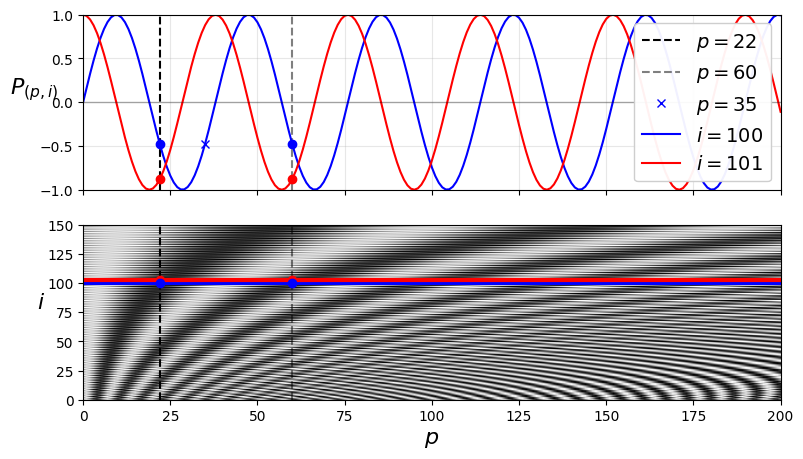

In [ ]:
import matplotlib.pyplot as plt
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(P[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.show()

# Multi-Head Attention

In [ ]:
N = 2   # instead of 6
num_heads = 8
dropout_rate = 0.1
n_units = 128       # for the first Dense Layer in each Feed Forward Block
encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)[:, tf.newaxis]
Z = encoder_in
for _ in range(N):
  skip = Z
  attn_layer = tf.keras.layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
  Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
  skip = Z
  Z = tf.keras.layers.Dense(n_units, activation='relu')(Z)
  Z = tf.keras.layers.Dense(embed_size)(Z)
  Z = tf.keras.layers.Dropout(dropout_rate)(Z)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [ ]:
encoder_pad_mask = tf.math.not_equal(decoder_input_ids, 0)[:, tf.newaxis]
decoder_pad_mask = tf.math.not_equal(decoder_input_ids, 0)[:, tf.newaxis]

causal_mask = tf.linalg.band_part(             # Creates lower triangular matrix
    tf.ones((batch_max_len_dec, batch_max_len_dec), tf.bool),  -1, 0)

In [ ]:
encoder_outputs = Z    # let's save the encoder's final outputs
Z = decoder_in
for _ in range(N):
  skip = Z
  attn_layer = tf.keras.layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
  Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
  skip = Z
  attn_layer = tf.keras.layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
  Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
  Z = tf.keras.layers.Dense(n_units, activation='relu')(Z)
  Z = tf.keras.layers.Dense(embed_size)(Z)
  Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))


In [ ]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation='softmax')(Z)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
              metrics=['accuracy'])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 156s 42ms/step - loss: 0.0958 - accuracy: 0.9857 - val_loss: 0.0036 - val_accuracy: 0.9994
Epoch 2/10
3125/3125 [==============================] - 125s 40ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.0031 - val_accuracy: 0.9994
Epoch 3/10
3125/3125 [==============================] - 123s 39ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 4/10
3125/3125 [==============================] - 123s 39ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0017 - val_accuracy: 0.9997
Epoch 5/10
3125/3125 [==============================] - 119s 38ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 6/10
3125/3125 [==============================] - 118s 38ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0023 - val_accuracy: 0.9995
Epoch 7/10
3125/3125 [==============================] - 128s 41ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0

# Hugging Face

In [12]:
import sys
import tensorflow as tf

In [2]:
if 'google.colab' in sys.modules:
 %pip install -q -U transformers
 %pip install -q -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but yo

In [3]:
from transformers import pipeline

classifier = pipeline('sentiment-analysis')   # many other tasks are avaliable
results = classifier('The actors were very convincing')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [4]:
classifier(["I am from India.", 'I am from Iraq.'])

[{'label': 'POSITIVE', 'score': 0.9896161556243896},
 {'label': 'NEGATIVE', 'score': 0.9811071157455444}]

In [5]:
model_name = 'huggingface/distilbert-base-uncased-finetuned-mnli'
classifier_mnli = pipeline('text-classification', model=model_name)
classifier_mnli("She loves me. [SEP] She loves me not")

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'contradiction', 'score': 0.6888470649719238}]

In [6]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [7]:
token_ids = tokenizer(["I like soccer.", 'We all love soccer!',
                       "Joe lived for a very long time. [SEP] Joe is old."],
                      padding=True, return_tensors='tf')
token_ids

{'input_ids': [[101, 1045, 2066, 4715, 1012, 102, 2057, 2035, 2293, 4715, 999, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [9]:
token_ids = tokenizer([("I like soccer.", "We all love soccer!"),
                       ("Joe lived for a very long time.", "Joe is old.")],
                      padding=True, return_tensors='tf')
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [10]:
outputs = model(token_ids)
outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.1123812 ,  1.1786786 ,  1.4101006 ],
       [-0.01478313,  1.0962478 , -0.9919961 ]], dtype=float32)>, hidden_states=None, attentions=None)

In [14]:
Y_probas = tf.keras.activations.softmax(outputs.logits)
Y_probas

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.01619703, 0.43523577, 0.54856724],
       [0.22655976, 0.6881726 , 0.0852677 ]], dtype=float32)>

In [29]:
sentences = [("Sky is blue", "Sky is red"), ("I love her", "She loves me")]
X_train = tokenizer(sentences, padding=True, return_tensors='tf').data
y_train = tf.constant([0, 2]) # contradiction, neutral
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer='nadam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2)

Epoch 1/2


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 71s 71s/step - loss: 1.1353 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 60ms/step - loss: 0.1433 - accuracy: 1.0000
